In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

In [136]:
def load_and_prepare(census_path, survey_path):
    """Load and merge datasets with suffixes"""
    census = pd.read_csv(census_path)
    survey = pd.read_csv(survey_path)
    return pd.merge(census, survey, on='geography_code', 
                   suffixes=('_census', '_survey'))

In [137]:
def extract_variable_group(merged_df, prefix):
    """
    Extract geography_code and all columns starting with given prefix
    into a new DataFrame
    
    Parameters:
    - merged_df: DataFrame from load_and_prepare()
    - prefix: Variable prefix to extract (e.g. 's01_')
    
    Returns:
    - DataFrame with geography_code and matching columns
    """
    # Find all columns matching the prefix
    cols = [col for col in merged_df.columns 
           if col.startswith(prefix) or col == 'geography_code']
    
    return merged_df[cols].copy()

In [138]:
def normalize_by_half_row_total(df):
    """
    Creates a new DataFrame with values normalized by 0.5 of row totals
    (excluding geography_code)
    
    Parameters:
        df: Input DataFrame with geography_code and value columns
        
    Returns:
        New DataFrame with geography_code and normalized values only
    """
    # Create new empty DataFrame with just geography_code
    norm_df = pd.DataFrame()
    norm_df['geography_code'] = df['geography_code']
    
    # Get all columns except geography_code
    value_cols = [col for col in df.columns if col != 'geography_code']
    
    # Calculate row totals (sum of census + survey values)
    row_totals = df[value_cols].sum(axis=1)
    
    # Add normalized columns to new DF
    for col in value_cols:
        norm_df[col] = df[col] / (0.5 * row_totals)
    
    return norm_df

In [139]:
def plot_census_vs_survey(df,group):
    # Find all columns with '_census' and '_survey'
    census_cols = [col for col in df.columns if '_census' in col]
    survey_cols = [col.replace('_census', '_survey') for col in census_cols]
    
    # Check if matching survey columns exist
    valid_pairs = []
    for c_col, s_col in zip(census_cols, survey_cols):
        if s_col in df.columns:
            valid_pairs.append((c_col, s_col))
    
    if not valid_pairs:
        raise ValueError("No matching '_census' and '_survey' columns found!")
    
    # Set up the plot
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(valid_pairs)))  # Different colors
    
    # Plot each pair
    for (c_col, s_col), color in zip(valid_pairs, colors):
        label = c_col.split('%')[-1].replace('_census', '')  # Clean label
        plt.scatter(df[c_col], df[s_col], color=color, label=label, alpha=0.7, s=0.5)
    
    # Add reference line and labels
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Agreement')
    plt.xlabel('Census Value')
    plt.ylabel('Survey Value')
    plt.title('Census vs. Survey: '+group)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(group+'plt.png')
    plt.show()

In [140]:
def plot_data(group):
    urban_rural_df = extract_variable_group(df,group)
    urban_rural_norm = normalize_by_half_row_total(urban_rural_df)
    plot_census_vs_survey(urban_rural_norm,group)


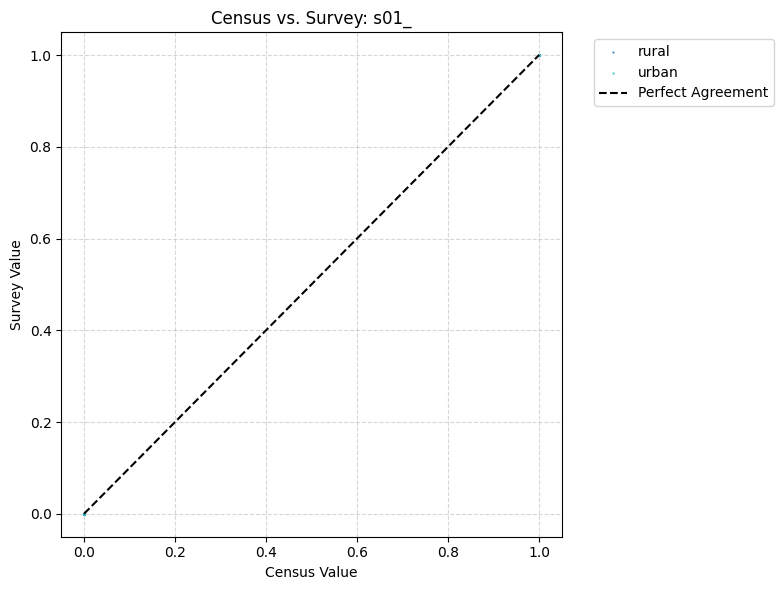

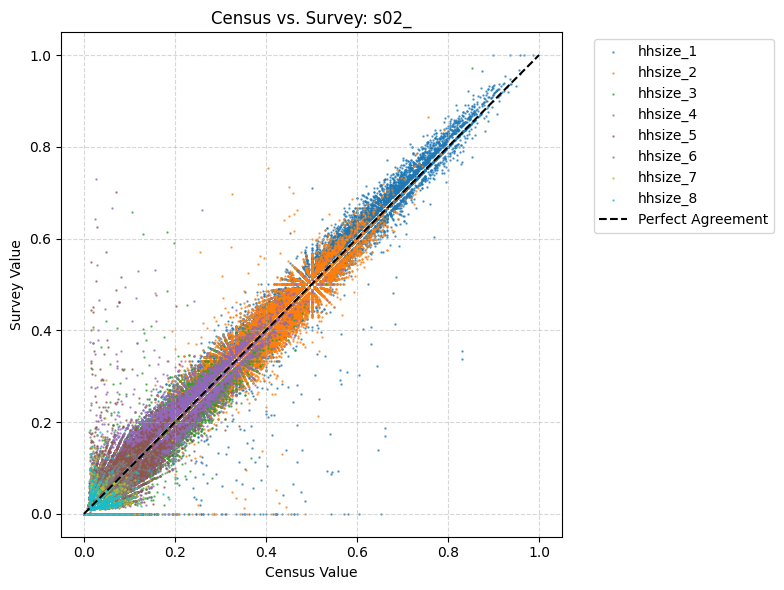

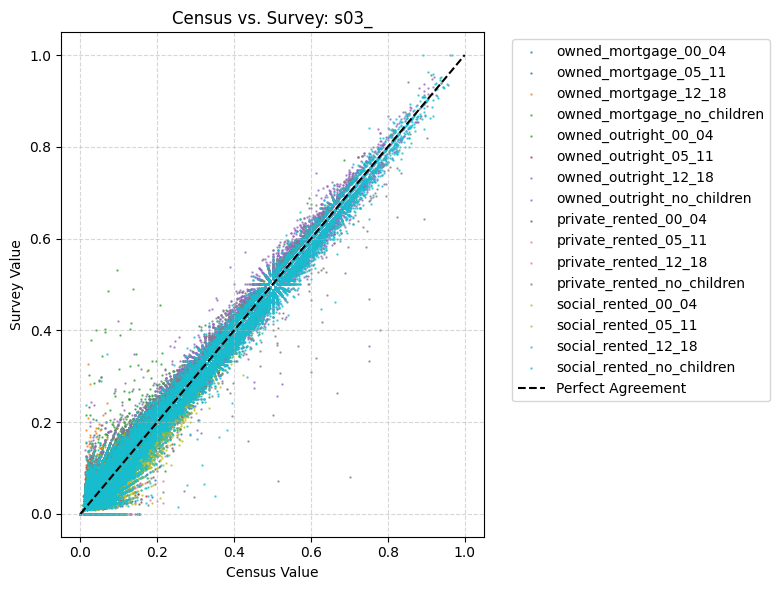

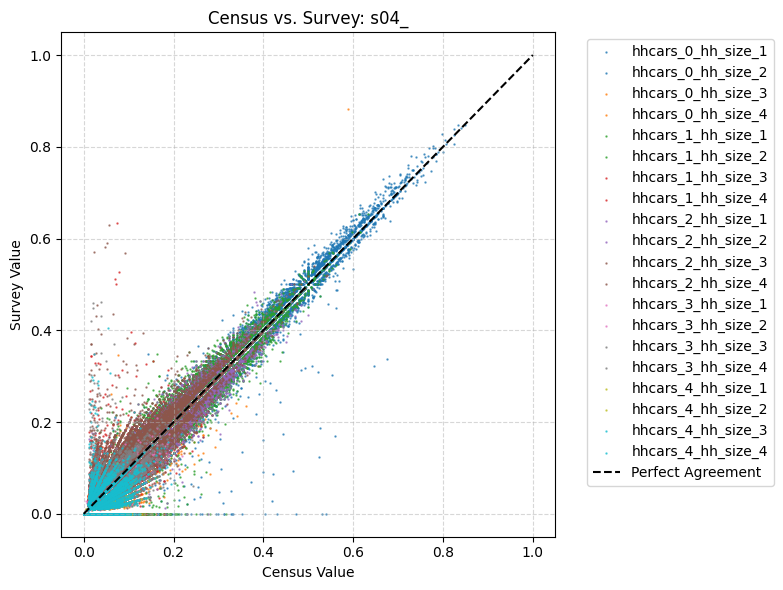

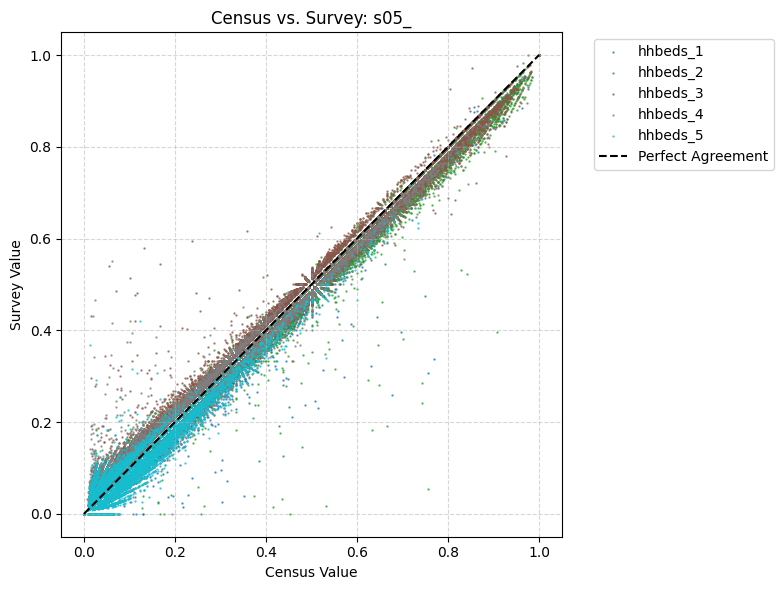

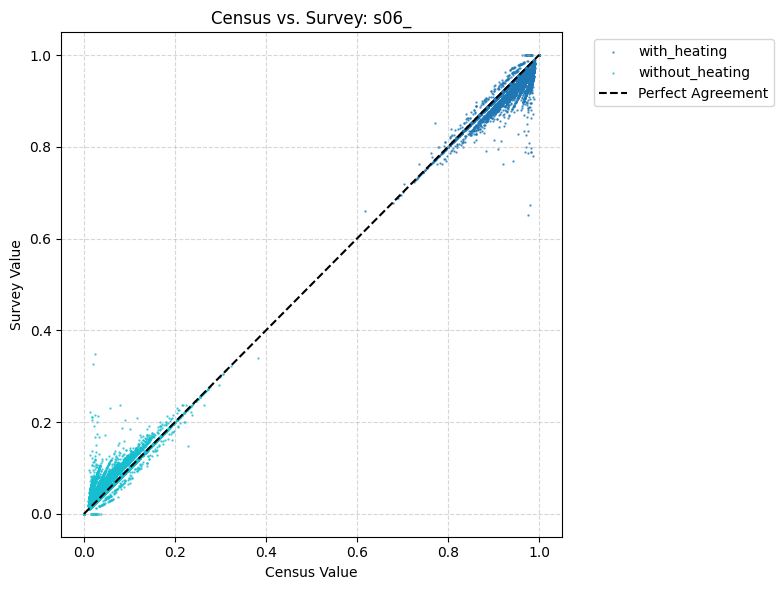

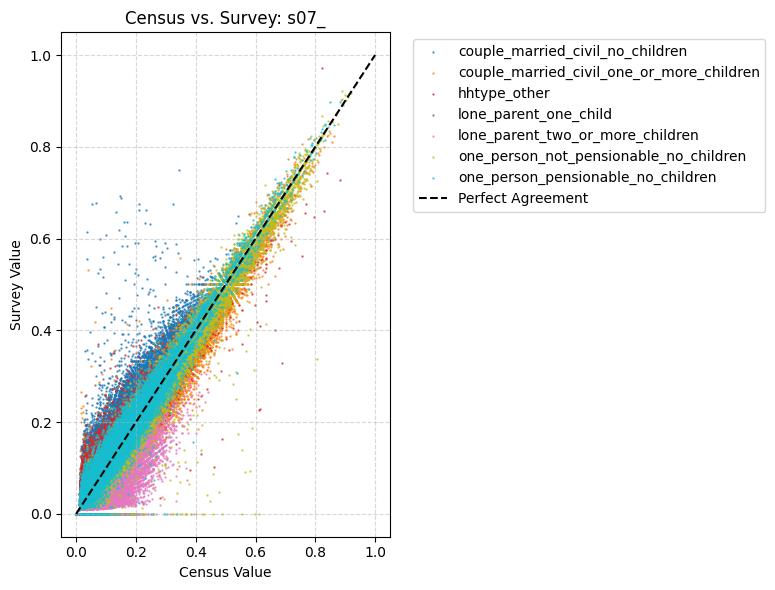

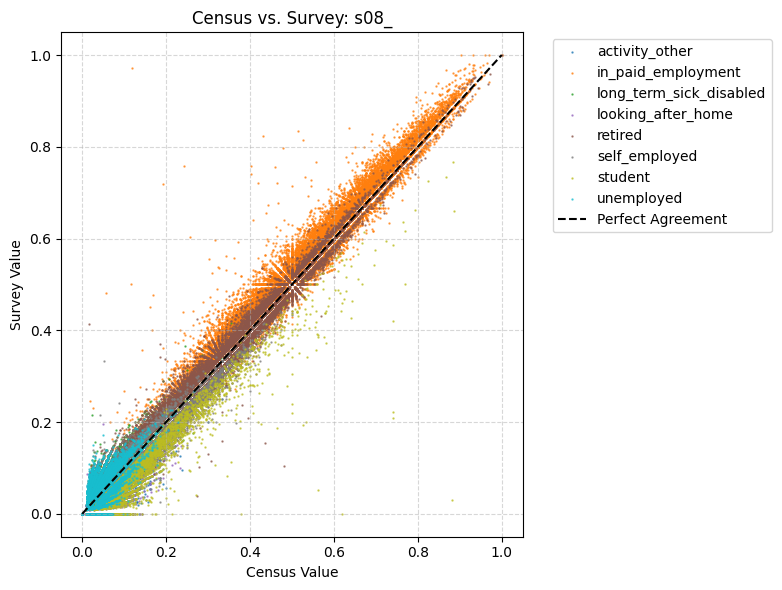

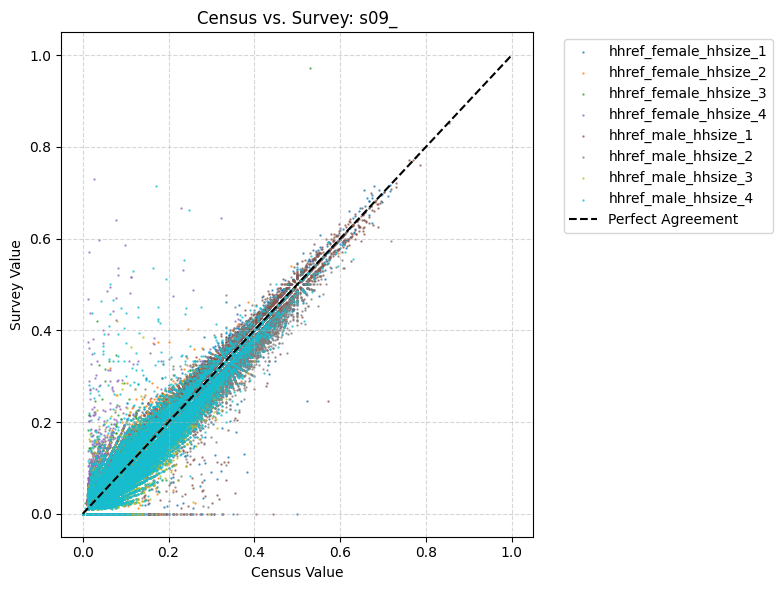

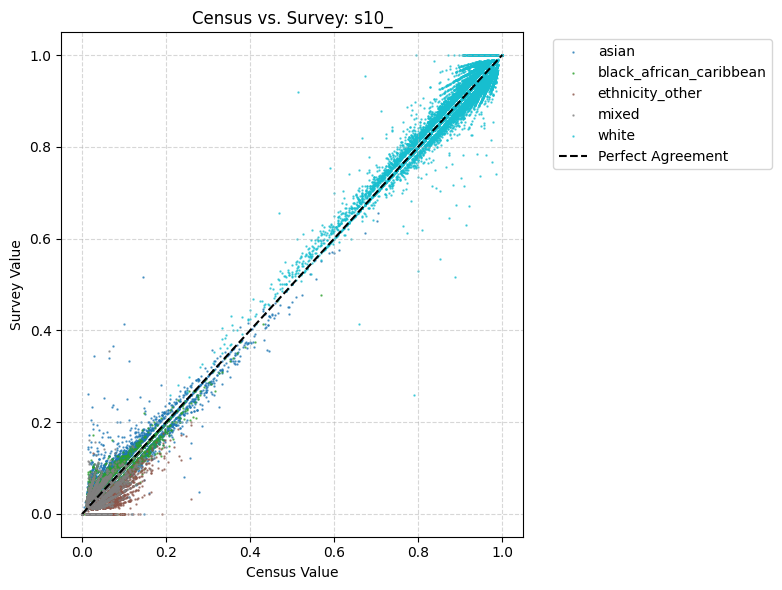

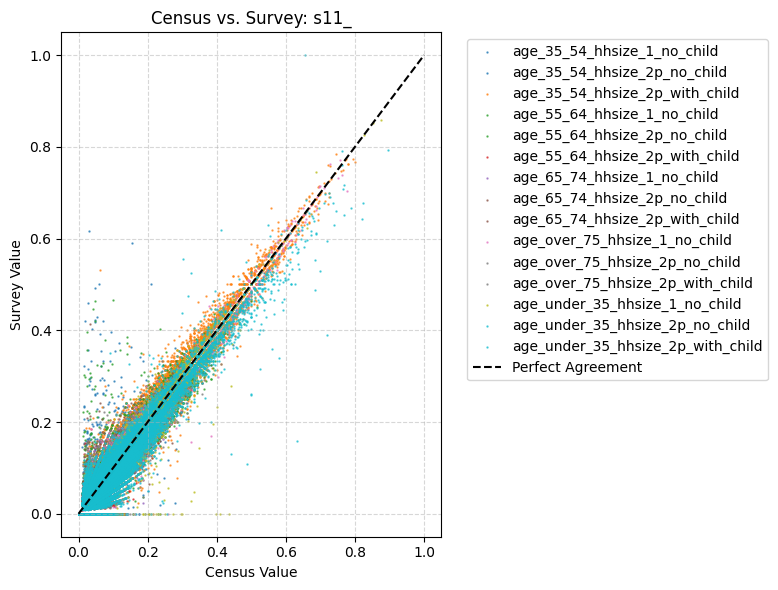

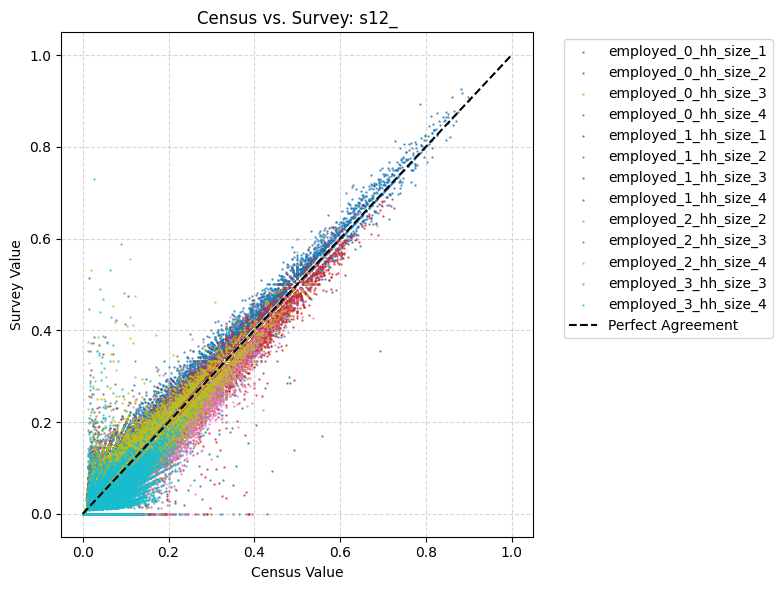

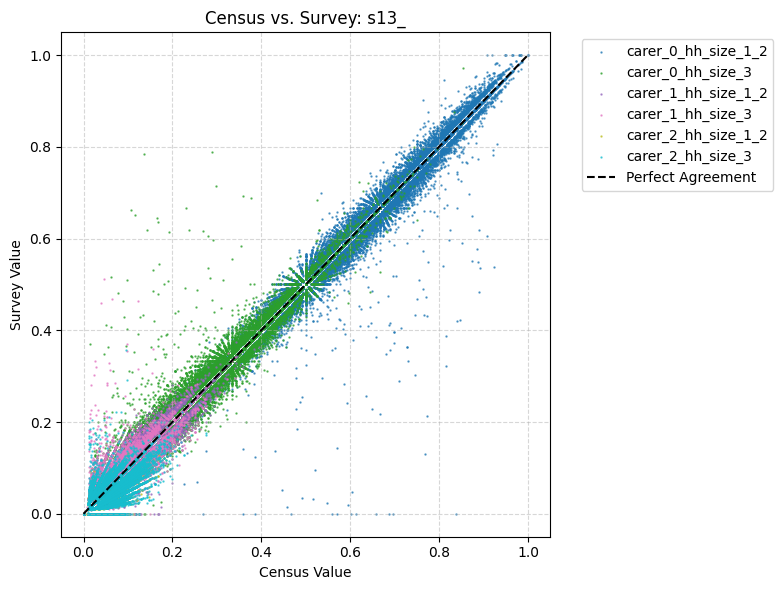

In [132]:
df = load_and_prepare('data/census2022_all_go.csv', 'results/synthPopSurvay0608.csv')
for g in ['s01_','s02_','s03_','s04_','s05_','s06_','s07_','s08_','s09_','s10_','s11_','s12_','s13_']:
    plot_data(g)

    

In [134]:
print("done")

done
